<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/VAE_project_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic VAE on  MNIST Dataset 
1. VAE
2. VAE + Classifier

VAE performance will be analyzed:
1. TSNE plot of latent space
2. Classifer performance - using loss with VAE+classifier, VAE only


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Masters-DS/CSCI-B659/project/vae-model1


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Masters-DS/CSCI-B659/project/vae-model1


In [0]:
%ls 

In [0]:
%%capture
!pip install tqdm six

!pip install bokeh
!pip install tensorboard
!pip install livelossplot

!pip install tensorboard

## Import Libraries

In [5]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
from livelossplot import PlotLosses
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from scipy.stats import norm
from sklearn import manifold

plt.style.use('fivethirtyeight')
%matplotlib inline

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Util Functions - For Plotting

In [0]:
## Show image
def imshow(img,title=None):
  """Imshow for Tensor."""
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)         
  
def plot_grid(inputs):
  # Make a grid from batch 
  out = torchvision.utils.make_grid(inputs,10,10)
  imshow(out, title="")
  
## Visualize some images in the dataset
def visualizeDataset(X):
  for i,image in enumerate(X):
    cv2.imshow(str(i),image)
    cv2.waitKey()
    cv2.destroyAllWindows()

def plot_loss(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  
def plot_accuracy(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  

## Scatter Plot
def scatterplot(x, y, ax, imageData, zoom):
  images = []
  imageSize = 28
  for i in range(len(x)):
    x0, y0 = x[i], y[i]
    
    # Convert to image
    img = imageData[i]*255.
    img = (img).numpy()
    img = img.astype(np.uint8).reshape([imageSize,imageSize])
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    # Note: OpenCV uses BGR and plt uses RGB
    image = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
    images.append(ax.add_artist(ab))
    
  ax.update_datalim(np.column_stack([x, y]))
  ax.autoscale()
  
  
import seaborn as sns
palette = np.array(sns.color_palette("hls", 10))

def plot_scatter(projection,labels):
    plt.scatter(projection[:,0], projection[:,1],c=[palette[i] for i in labels])
    
  
  
# Show dataset images with T-sne projection of pixel space
def tsne_projection_latent_space(X, image_size, display=True):
    # Compute t-SNE embedding of latent space
    
    
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1,image_size*image_size*1]))

    # Plot images according to t-sne embedding
    if display:
        
        fig, ax = plt.subplots()
        scatterplot(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne
      
      
# Show dataset images with T-sne projection of pixel space
def tsne_projection_latent_space2(X, Y, image_size, display=True):
    # Compute t-SNE embedding of latent space
    
    print("tsne projection of latent space...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1,image_size*image_size*1]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        plot_scatter(X_tsne, Y)
        plt.show()
    else:
        return X_tsne
      


## TensorBoard Utilities

In [45]:
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

## Import tensor flow library
class TensorBoardLogger(object):
  
  """
  Initialize the summary writer
  """
  def __init__(self, log_dir):
    "create summary writer"
    self.writer = tf.summary.FileWriter(log_dir)
  
  """
  Add scalar
  """
  def scalar_summary(self, tag, value, step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
    
  """
  Add images
  """
  def image_summary(self, tag, images, step):
    """Log a list of images."""

    img_summaries = []
    for i, img in enumerate(images):
        s = BytesIO()
        
        new_p = Image.fromarray(img)
        if new_p.mode != 'L':
          new_p = new_p.convert('L')
    
        new_p.save(s, format="png")

        # Create an Image object
        img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])
        # Create a Summary value
        img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

    # Create and write Summary
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
        
  def histo_summary(self, tag, values, step, bins=1000):
      """Log a histogram of the tensor of values."""

      # Create a histogram using numpy
      counts, bin_edges = np.histogram(values, bins=bins)

      # Fill the fields of the histogram proto
      hist = tf.HistogramProto()
      hist.min = float(np.min(values))
      hist.max = float(np.max(values))
      hist.num = int(np.prod(values.shape))
      hist.sum = float(np.sum(values))
      hist.sum_squares = float(np.sum(values**2))

      # Drop the start of the first bin
      bin_edges = bin_edges[1:]

      # Add bin edges and counts
      for edge in bin_edges:
          hist.bucket_limit.append(edge)
      for c in counts:
          hist.bucket.append(c)

      # Create and write Summary
      summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
      self.writer.add_summary(summary, step)
      self.writer.flush()
      
      
      
import os

def make_dirs(dirname):
  if not os.path.exists(dirname):
    os.makedirs(dirname)
    
    
#make_dirs("logs")
%ls

## Logging
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
      

logs/   ngrok-stable-linux-amd64.zip    ngrok-stable-linux-amd64.zip.2
ngrok*  ngrok-stable-linux-amd64.zip.1
--2019-04-07 13:49:58--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.145.109, 52.55.191.55, 52.73.9.93, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.145.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  14.28M  6.00MB/s    in 2.4s    

2019-04-07 13:50:01 (6.00 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://1082717c.ngrok.io


## Params

In [8]:
class Params:
  nb_latents = 5
  batch_size = 128
  epochs = 20
  log_interval = 100
  save_interval = 1000

  
torch.manual_seed(5)

## Metrics

In [0]:
### Metrics - Base Class For all Metrics
class Metric:
  def __init__(self):
    pass
  def __call__(self, outputs, target, loss):
    raise NotImplementedError
    
  def reset(self):
    raise NotImplementedError
    
  def value(self):
    raise NotImplementedError
    
  def name(self):
    raise NotImplementedError
    
## Accuracy Metric
class AccumulatedAccuracyMetric(Metric):
  def __init__(self):
      self.correct = 0
      self.total = 0
      
  def __call__(self, outputs, target):
      # Track the accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (target == argmax.squeeze()).float().sum()
      self.correct += accuracy 
      self.total += target.size(0)
      return self.value()
  
  def reset(self):
      self.correct = 0
      self.total = 0

  def value(self):
      return 100 * float(self.correct) / self.total

  def name(self):
      return 'Accuracy'
    
    
## Loss
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )

## DataLoader - MNIST DataSet

In [0]:
path="/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework3/"

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST(os.path.join(path,"MNIST/data"),train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=True)

In [11]:
print(f"Total number of train images: {len(train_dataset)}, total number of test images: {len(test_dataset)}, total number of train batches: {len(train_loader)}")

Total number of train images: 60000, total number of test images: 10000, total number of train batches: 469


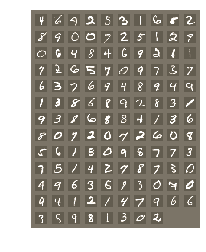

In [12]:
class_names = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
inputs, classes = next(iter(train_loader))
plot_grid(inputs)

## CNN Network

In [0]:
class ConvVAE(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAE, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Linear(1024, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 1024)
        
        
        
        self.fc4 = nn.Linear(1024,7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
    
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = (self.conv1(x))
        x =  (self.conv2(x))
        x =  (self.conv3(x))
        x =  (self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
        return self.sigmoid(x)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [85]:
model = ConvVAE(Params.nb_latents)
if is_cuda:
  model = model.to(device)
  
print(model)

ConvVAE(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc_mean): Linear(in_features=256, out_features=5, bias=True)
  (fc_std): Linear(in_features=256, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=256, bias=True)
  (fc3): Linear(in_features=256

## Loss Function

In [0]:
### Loss Function

def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction="sum")
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  return BCE , KLD

## Latent Space Visualization

In [0]:
criterion = nn.CrossEntropyLoss()
logger = TensorBoardLogger("./logs") 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath="logs",istrain=True):
  model.eval()
  
  if isinstance(model,ConvVAE):
    
    datapoint = datapoint.unsqueeze(0)
    datapoint = datapoint.to(device)
    mu, _ = model.encode(datapoint)
  else:
    mu, _ = model.encode(datapoint.view(-1))
  
  recons = torch.zeros((7, nb_latents, 28, 28))
 
  
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val
      recon = model.decode(muc).cpu()
      
      recons[i, zi] = recon.view(28, 28) 
  
  ## Reconstruction of output along every dimension
  name = "train_reconstruction_" if istrain else "test_reconstruction_"
  filename = os.path.join(dirpath,  name + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 28, 28), filename, nrow=nb_latents, pad_value=1)
  
  
### Plot TSNE for latent space
# Show dataset images with T-sne projection of latent space encoding
def visualize_tsne_of_input(X,labels, model, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    
    X_encoded, _ = model.encode(X)
    
    # Compute t-SNE embedding of latent space
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.data.detach().cpu())

    # Plot images according to t-sne embedding
    if display:
        #print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        plot_scatter(X_tsne,labels)
        plt.show()
    else:
        return X_tsne
  

  

## Train Epoch

In [0]:
## Training
from tqdm import trange

## train epoch
def train_epoch(epoch):
  model.train()
  
  
  loss_log = RunningAverage()
  
  ## Test reconstruction test
  testpoint = torch.Tensor(train_loader.dataset[0][0])
  with trange(len(train_loader),unit_scale=False, unit_divisor=1024) as t:
    for batch_idx, (data, labels ) in enumerate(train_loader):
      data = data.to(device)

      optimizer.zero_grad()
      batch_size = data.size(0)

      recon_batch, mu, logvar = model(data)


      ## Loss of VAE
      bcloss, kld = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
      loss = bcloss+kld
      loss.backward()

      loss_log.update(loss.item() / len(data))
      
      
      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss, 'binary_crossentropy':bcloss,'kld':kld }

      for tag, value in info.items():
        logger.scalar_summary(tag, value, epoch+1)

      # 2. Log values and gradients of the parameters (histogram summary)
      for tag, value in model.named_parameters():
        tag = tag.replace('.', '/')
        logger.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
        logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)


      optimizer.step()
      

      ## Accuracy 
      if batch_idx % Params.log_interval == 0:

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, \t '.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item() / len(data)))
        
      if batch_idx % 200 == 0:
        ## end of training
        traverse_latents(model, testpoint, Params.nb_latents, epoch, batch_idx)
        visualize_tsne_of_input(data,labels,model,display=True)
        
        ## train reconstruction
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],recon_batch.view(Params.batch_size, 1, 28, 28)[:n]])
        save_image(comparison.cpu(),'./logs/all_class_train_reconstruction_' + str(epoch) + '.png', nrow=n)
    
      
    t.set_postfix(loss=loss.data.tolist())
    t.update()
    
    print("==> Epoch {}, average loss: {:.4f}".format(epoch, loss_log()))

  return loss_log()


## Test Epoch

In [0]:
## Test Epoch
"""
Test
"""
def test_epoch(epoch):
    model.eval()
    test_loss = RunningAverage()
    
    ## Test reconstruction test
    testpoint = torch.Tensor(test_loader.dataset[0][0])
  
    with torch.no_grad():
        for i, (data,labels) in enumerate(test_loader):
            data = data.to(device)
             
            batch_size = data.size(0)
            recon_batch, mu, logvar = model(data)
            
            ## Loss of VAE
            bceloss, kld = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
            loss = bceloss + kld
            test_loss.update(loss.item() / len(data))
            # 1. Log scalar values (scalar summary)
            info = { 'test_loss': loss, 'test_bce':bceloss , 'test_kld':kld}

            for tag, value in info.items():
                logger.scalar_summary(tag, value, epoch+1)
            
            traverse_latents(model, testpoint, Params.nb_latents, epoch, i, istrain=False)
            
            ## test reconstruction
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],recon_batch[:n]])
            save_image(comparison.cpu(),'./logs/all_class_test_reconstruction_' + str(epoch) + '.png', nrow=n)
    
   
    return test_loss()

## Training and Evaluation

  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: -8509.915039, 	 
Computing latent space projection...


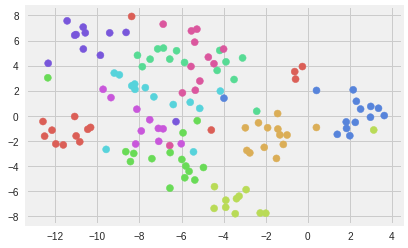

Train Epoch: 0 [12800/60000 (21%)]	Loss: -9917.336914, 	 
Train Epoch: 0 [25600/60000 (43%)]	Loss: -10135.536133, 	 
Computing latent space projection...


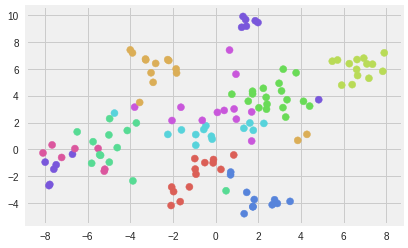

Train Epoch: 0 [38400/60000 (64%)]	Loss: -9938.360352, 	 
Train Epoch: 0 [51200/60000 (85%)]	Loss: -10095.254883, 	 
Computing latent space projection...


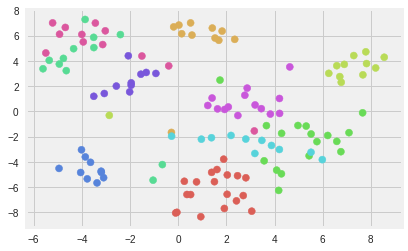

  0%|          | 1/469 [05:33<43:18:53, 333.19s/it, loss=-9.66e+5]


==> Epoch 0, average loss: -9993.5465


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: -7818.741211, 	 
Computing latent space projection...


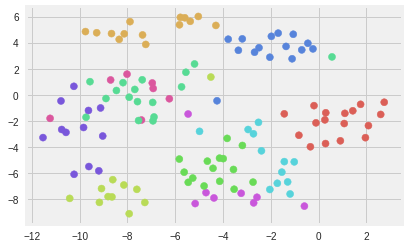

Train Epoch: 1 [12800/60000 (21%)]	Loss: -9972.732422, 	 
Train Epoch: 1 [25600/60000 (43%)]	Loss: -10249.600586, 	 
Computing latent space projection...


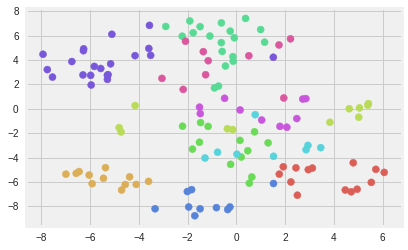

Train Epoch: 1 [38400/60000 (64%)]	Loss: -10097.278320, 	 
Train Epoch: 1 [51200/60000 (85%)]	Loss: -10227.409180, 	 
Computing latent space projection...


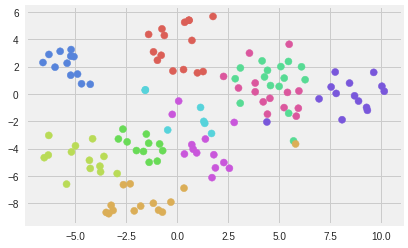

  0%|          | 1/469 [05:30<43:00:16, 330.80s/it, loss=-9.84e+5]


==> Epoch 1, average loss: -10121.0387


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: -7748.834473, 	 
Computing latent space projection...


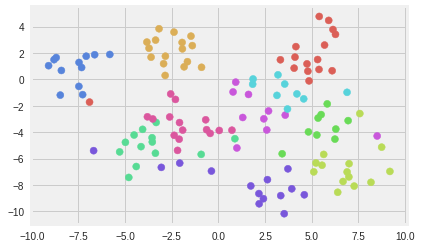

Train Epoch: 2 [12800/60000 (21%)]	Loss: -10196.206055, 	 
Train Epoch: 2 [25600/60000 (43%)]	Loss: -10133.042969, 	 
Computing latent space projection...


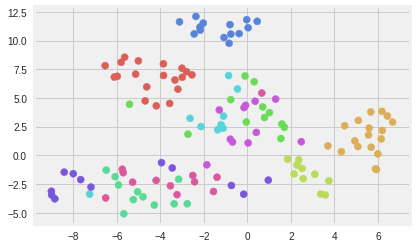

Train Epoch: 2 [38400/60000 (64%)]	Loss: -10183.081055, 	 
Train Epoch: 2 [51200/60000 (85%)]	Loss: -10141.540039, 	 
Computing latent space projection...


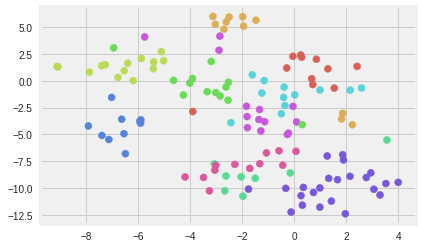

  0%|          | 1/469 [05:21<41:44:00, 321.03s/it, loss=-9.98e+5]


==> Epoch 2, average loss: -10198.1373


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: -7461.387695, 	 
Computing latent space projection...


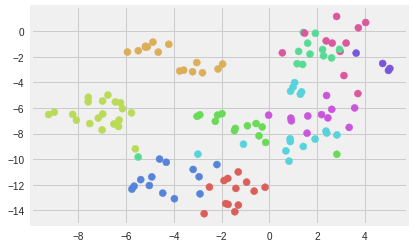

Train Epoch: 3 [12800/60000 (21%)]	Loss: -10203.417969, 	 
Train Epoch: 3 [25600/60000 (43%)]	Loss: -10325.971680, 	 
Computing latent space projection...


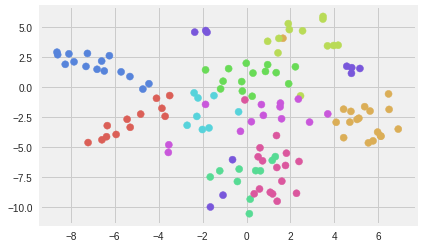

Train Epoch: 3 [38400/60000 (64%)]	Loss: -10575.435547, 	 
Train Epoch: 3 [51200/60000 (85%)]	Loss: -10321.208984, 	 
Computing latent space projection...


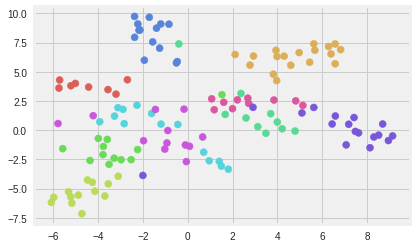

  0%|          | 1/469 [05:00<39:02:30, 300.32s/it, loss=-9.85e+5]


==> Epoch 3, average loss: -10281.4633


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: -6983.236816, 	 
Computing latent space projection...


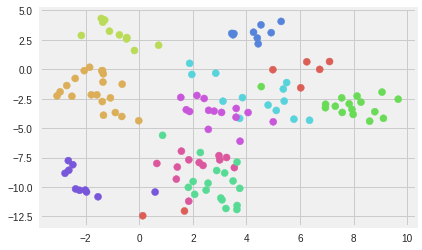

Train Epoch: 4 [12800/60000 (21%)]	Loss: -10491.192383, 	 
Train Epoch: 4 [25600/60000 (43%)]	Loss: -10470.092773, 	 
Computing latent space projection...


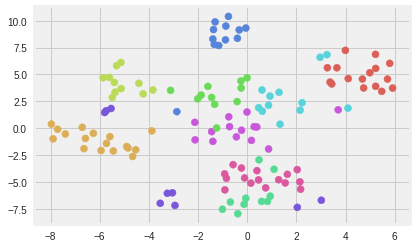

Train Epoch: 4 [38400/60000 (64%)]	Loss: -10238.635742, 	 
Train Epoch: 4 [51200/60000 (85%)]	Loss: -10217.456055, 	 
Computing latent space projection...


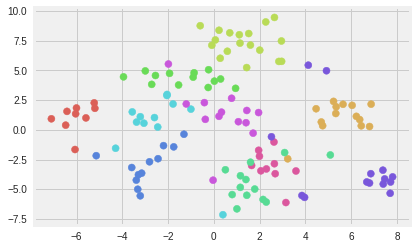

  0%|          | 1/469 [04:42<36:40:31, 282.12s/it, loss=-9.84e+5]


==> Epoch 4, average loss: -10363.2087


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: -7849.407715, 	 
Computing latent space projection...


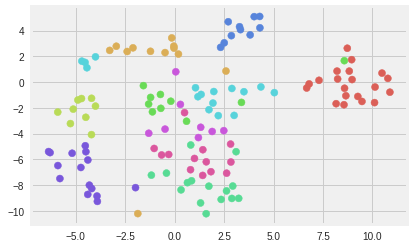

Train Epoch: 5 [12800/60000 (21%)]	Loss: -10525.695312, 	 
Train Epoch: 5 [25600/60000 (43%)]	Loss: -10537.892578, 	 
Computing latent space projection...


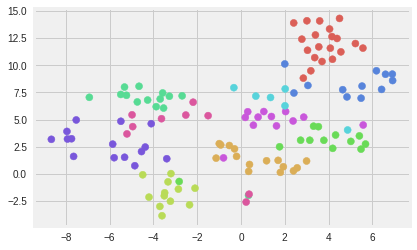

Train Epoch: 5 [38400/60000 (64%)]	Loss: -10598.311523, 	 
Train Epoch: 5 [51200/60000 (85%)]	Loss: -10479.300781, 	 
Computing latent space projection...


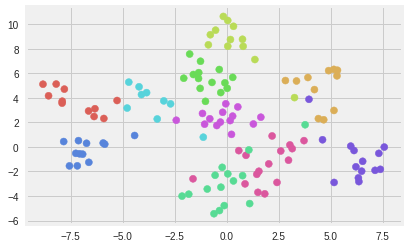

  0%|          | 1/469 [04:41<36:38:49, 281.90s/it, loss=-1e+6]


==> Epoch 5, average loss: -10402.4388


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: -8011.450195, 	 
Computing latent space projection...


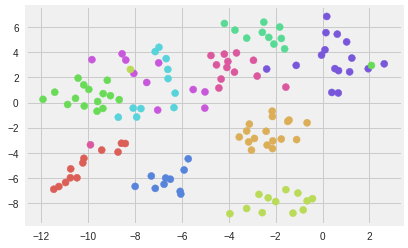

Train Epoch: 6 [12800/60000 (21%)]	Loss: -10366.997070, 	 
Train Epoch: 6 [25600/60000 (43%)]	Loss: -10351.172852, 	 
Computing latent space projection...


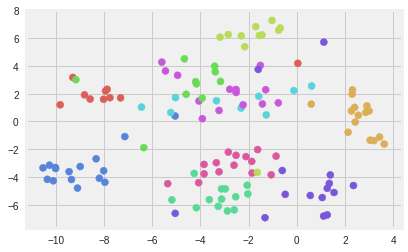

Train Epoch: 6 [38400/60000 (64%)]	Loss: -10641.994141, 	 
Train Epoch: 6 [51200/60000 (85%)]	Loss: -10560.025391, 	 
Computing latent space projection...


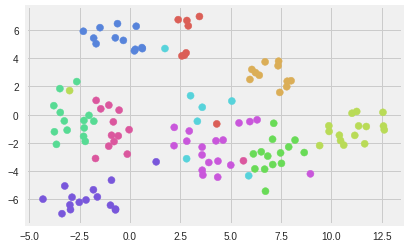

  0%|          | 1/469 [04:41<36:39:32, 281.99s/it, loss=-9.99e+5]


==> Epoch 6, average loss: -10454.4362


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: -7459.020020, 	 
Computing latent space projection...


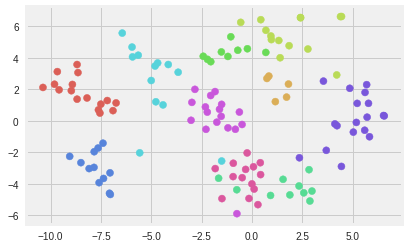

Train Epoch: 7 [12800/60000 (21%)]	Loss: -10682.727539, 	 
Train Epoch: 7 [25600/60000 (43%)]	Loss: -10412.875977, 	 
Computing latent space projection...


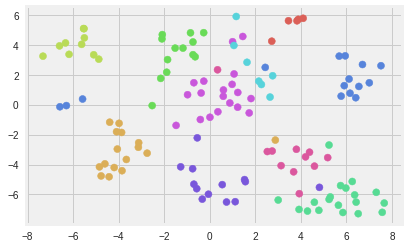

Train Epoch: 7 [38400/60000 (64%)]	Loss: -10463.955078, 	 
Train Epoch: 7 [51200/60000 (85%)]	Loss: -10499.119141, 	 
Computing latent space projection...


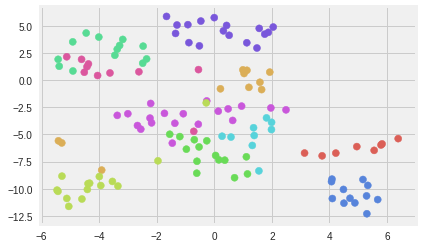

  0%|          | 1/469 [04:46<37:15:50, 286.65s/it, loss=-9.66e+5]


==> Epoch 7, average loss: -10483.3836


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: -7902.237305, 	 
Computing latent space projection...


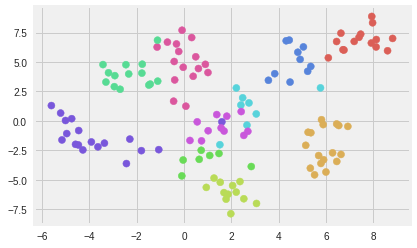

Train Epoch: 8 [12800/60000 (21%)]	Loss: -10555.797852, 	 
Train Epoch: 8 [25600/60000 (43%)]	Loss: -10443.104492, 	 
Computing latent space projection...


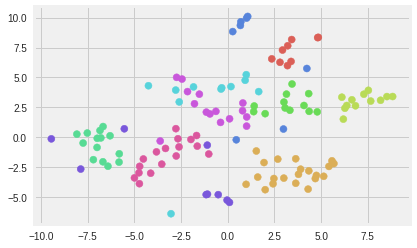

Train Epoch: 8 [38400/60000 (64%)]	Loss: -10476.738281, 	 
Train Epoch: 8 [51200/60000 (85%)]	Loss: -10491.969727, 	 
Computing latent space projection...


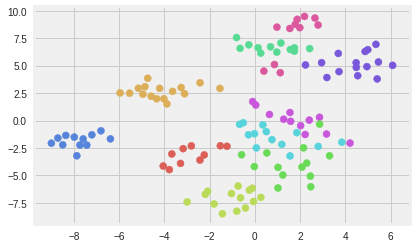

  0%|          | 1/469 [04:46<37:16:39, 286.75s/it, loss=-1.01e+6]


==> Epoch 8, average loss: -10517.1481


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: -7099.946289, 	 
Computing latent space projection...


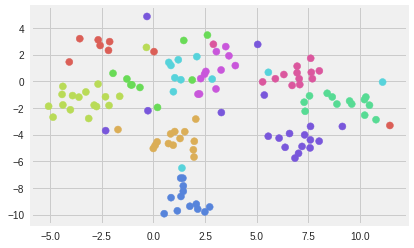

Train Epoch: 9 [12800/60000 (21%)]	Loss: -10674.090820, 	 
Train Epoch: 9 [25600/60000 (43%)]	Loss: -10609.452148, 	 
Computing latent space projection...


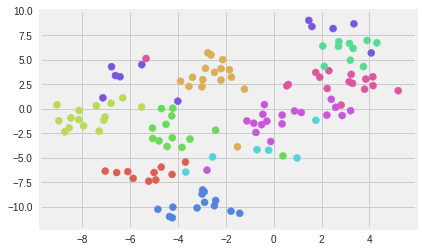

Train Epoch: 9 [38400/60000 (64%)]	Loss: -10742.133789, 	 
Train Epoch: 9 [51200/60000 (85%)]	Loss: -10615.158203, 	 
Computing latent space projection...


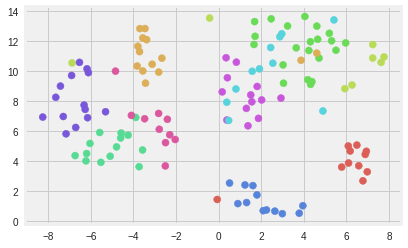

  0%|          | 1/469 [05:04<39:38:17, 304.91s/it, loss=-1e+6]


==> Epoch 9, average loss: -10579.8986


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: -7524.603027, 	 
Computing latent space projection...


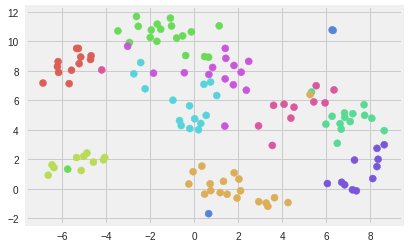

Train Epoch: 10 [12800/60000 (21%)]	Loss: -10709.188477, 	 
Train Epoch: 10 [25600/60000 (43%)]	Loss: -10424.665039, 	 
Computing latent space projection...


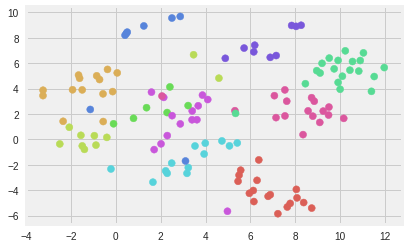

Train Epoch: 10 [38400/60000 (64%)]	Loss: -10906.762695, 	 
Train Epoch: 10 [51200/60000 (85%)]	Loss: -10658.426758, 	 
Computing latent space projection...


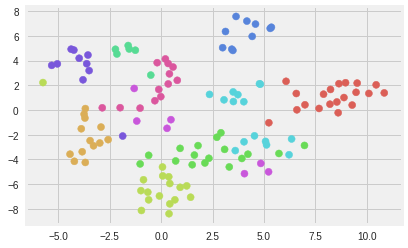

  0%|          | 1/469 [04:58<38:47:21, 298.38s/it, loss=-1.03e+6]


==> Epoch 10, average loss: -10613.8456


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: -7508.647949, 	 
Computing latent space projection...


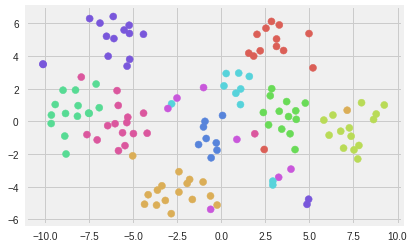

Train Epoch: 11 [12800/60000 (21%)]	Loss: -10660.375977, 	 
Train Epoch: 11 [25600/60000 (43%)]	Loss: -10811.724609, 	 
Computing latent space projection...


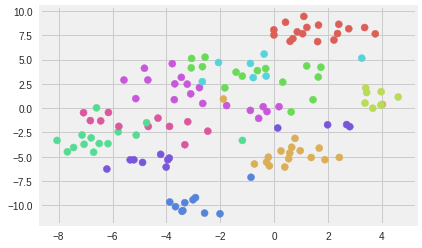

Train Epoch: 11 [38400/60000 (64%)]	Loss: -10593.633789, 	 
Train Epoch: 11 [51200/60000 (85%)]	Loss: -10495.299805, 	 
Computing latent space projection...


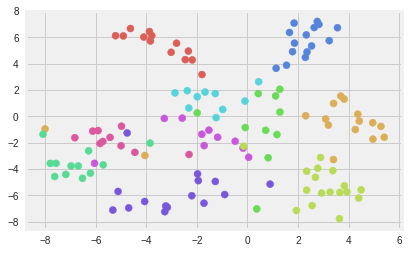

  0%|          | 1/469 [05:01<39:13:01, 301.67s/it, loss=-1.03e+6]


==> Epoch 11, average loss: -10627.1180


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: -7642.339355, 	 
Computing latent space projection...


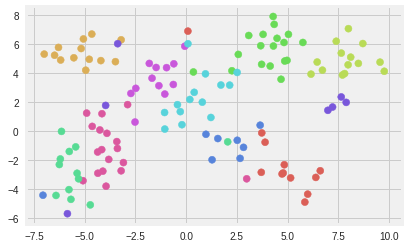

Train Epoch: 12 [12800/60000 (21%)]	Loss: -10768.796875, 	 
Train Epoch: 12 [25600/60000 (43%)]	Loss: -10632.283203, 	 
Computing latent space projection...


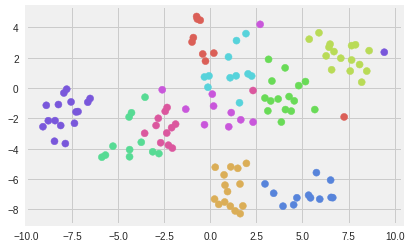

Train Epoch: 12 [38400/60000 (64%)]	Loss: -10761.230469, 	 
Train Epoch: 12 [51200/60000 (85%)]	Loss: -10518.933594, 	 
Computing latent space projection...


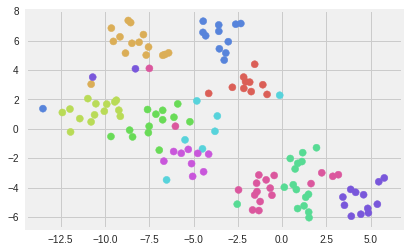

  0%|          | 1/469 [05:09<40:15:30, 309.68s/it, loss=-1.01e+6]


==> Epoch 12, average loss: -10640.7443


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: -7491.902832, 	 
Computing latent space projection...


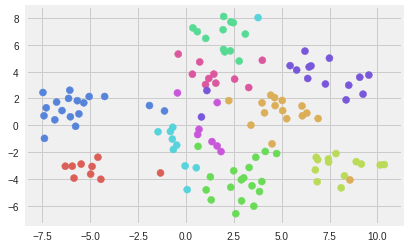

Train Epoch: 13 [12800/60000 (21%)]	Loss: -10599.865234, 	 
Train Epoch: 13 [25600/60000 (43%)]	Loss: -10505.494141, 	 
Computing latent space projection...


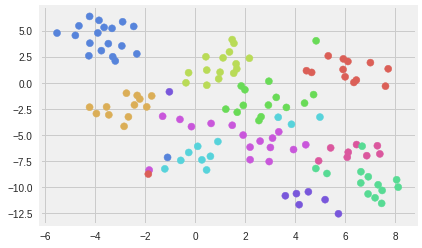

Train Epoch: 13 [38400/60000 (64%)]	Loss: -10815.049805, 	 
Train Epoch: 13 [51200/60000 (85%)]	Loss: -10617.041992, 	 
Computing latent space projection...


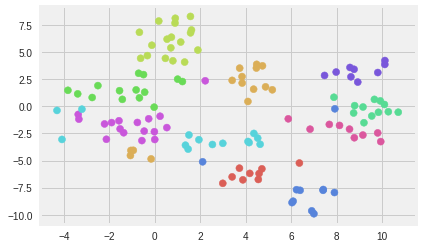

  0%|          | 1/469 [05:04<39:36:15, 304.65s/it, loss=-1.03e+6]


==> Epoch 13, average loss: -10659.5489


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: -7787.219238, 	 
Computing latent space projection...


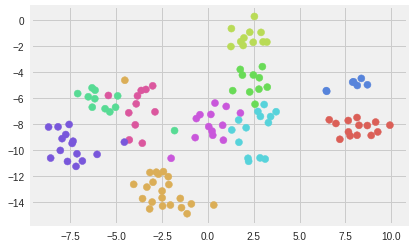

Train Epoch: 14 [12800/60000 (21%)]	Loss: -10845.832031, 	 
Train Epoch: 14 [25600/60000 (43%)]	Loss: -10512.330078, 	 
Computing latent space projection...


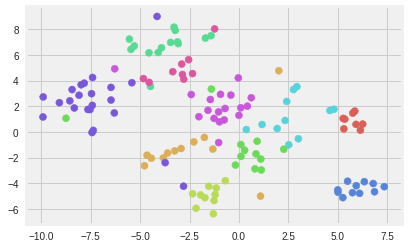

Train Epoch: 14 [38400/60000 (64%)]	Loss: -10991.677734, 	 
Train Epoch: 14 [51200/60000 (85%)]	Loss: -10795.200195, 	 
Computing latent space projection...


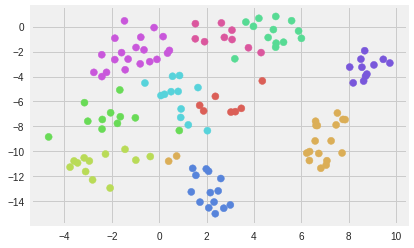

  0%|          | 1/469 [05:01<39:09:48, 301.26s/it, loss=-1.02e+6]


==> Epoch 14, average loss: -10706.0214


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: -7421.901367, 	 
Computing latent space projection...


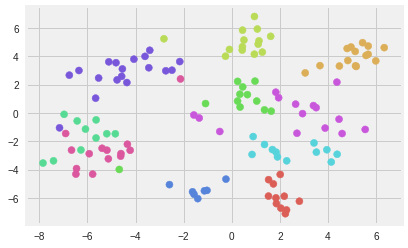

Train Epoch: 15 [12800/60000 (21%)]	Loss: -10632.524414, 	 
Train Epoch: 15 [25600/60000 (43%)]	Loss: -10694.494141, 	 
Computing latent space projection...


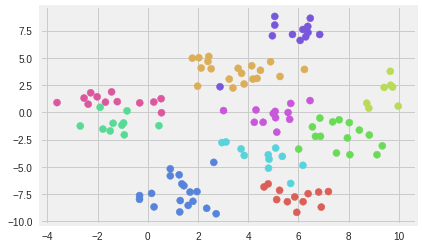

Train Epoch: 15 [38400/60000 (64%)]	Loss: -10860.968750, 	 
Train Epoch: 15 [51200/60000 (85%)]	Loss: -10455.246094, 	 
Computing latent space projection...


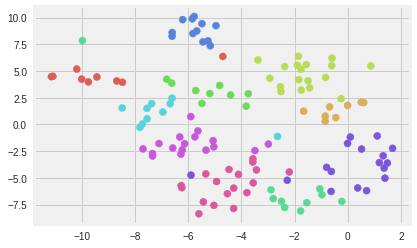

  0%|          | 1/469 [05:00<39:07:31, 300.97s/it, loss=-1.02e+6]


==> Epoch 15, average loss: -10729.0985


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 16 [0/60000 (0%)]	Loss: -7546.695801, 	 
Computing latent space projection...


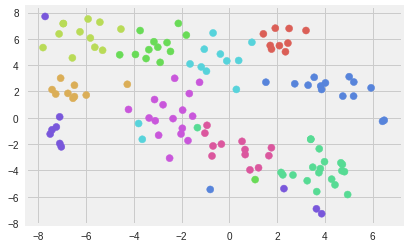

Train Epoch: 16 [12800/60000 (21%)]	Loss: -10747.334961, 	 
Train Epoch: 16 [25600/60000 (43%)]	Loss: -10792.571289, 	 
Computing latent space projection...


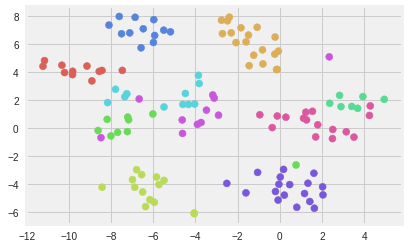

Train Epoch: 16 [38400/60000 (64%)]	Loss: -10691.287109, 	 
Train Epoch: 16 [51200/60000 (85%)]	Loss: -10831.118164, 	 
Computing latent space projection...


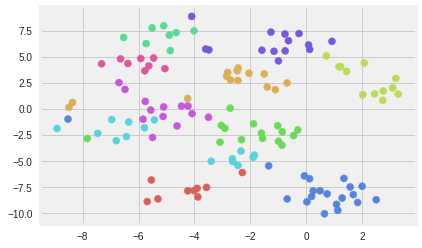

  0%|          | 1/469 [05:01<39:12:28, 301.60s/it, loss=-1.02e+6]


==> Epoch 16, average loss: -10735.3658


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 17 [0/60000 (0%)]	Loss: -7657.392578, 	 
Computing latent space projection...


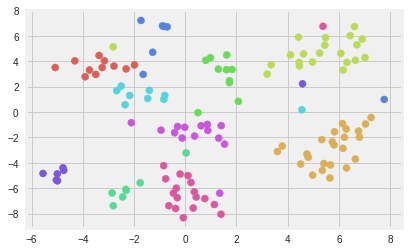

Train Epoch: 17 [12800/60000 (21%)]	Loss: -10701.902344, 	 
Train Epoch: 17 [25600/60000 (43%)]	Loss: -10832.788086, 	 
Computing latent space projection...


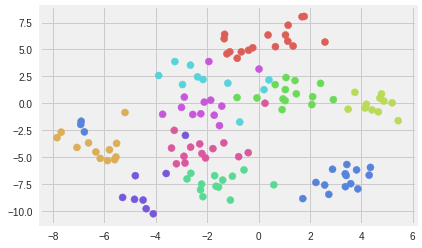

Train Epoch: 17 [38400/60000 (64%)]	Loss: -10859.949219, 	 
Train Epoch: 17 [51200/60000 (85%)]	Loss: -10775.600586, 	 
Computing latent space projection...


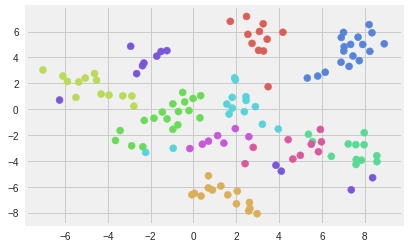

  0%|          | 1/469 [04:59<38:57:36, 299.69s/it, loss=-1.04e+6]


==> Epoch 17, average loss: -10740.2990


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 18 [0/60000 (0%)]	Loss: -7651.441406, 	 
Computing latent space projection...


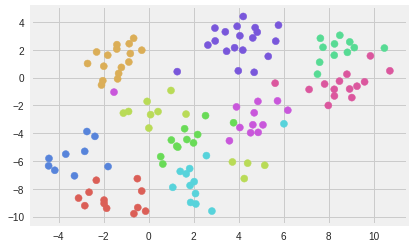

Train Epoch: 18 [12800/60000 (21%)]	Loss: -10950.546875, 	 
Train Epoch: 18 [25600/60000 (43%)]	Loss: -10574.298828, 	 
Computing latent space projection...


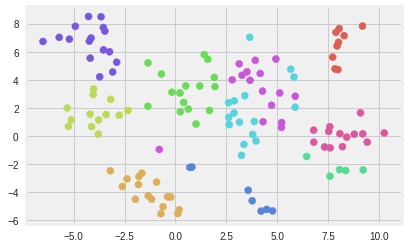

Train Epoch: 18 [38400/60000 (64%)]	Loss: -10791.136719, 	 
Train Epoch: 18 [51200/60000 (85%)]	Loss: -10880.025391, 	 
Computing latent space projection...


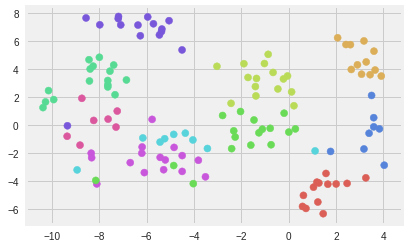

  0%|          | 1/469 [05:08<40:04:09, 308.23s/it, loss=-1.02e+6]


==> Epoch 18, average loss: -10759.6003


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 19 [0/60000 (0%)]	Loss: -7516.931641, 	 
Computing latent space projection...


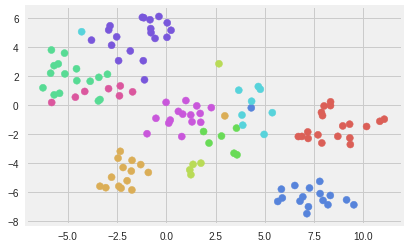

Train Epoch: 19 [12800/60000 (21%)]	Loss: -10542.139648, 	 
Train Epoch: 19 [25600/60000 (43%)]	Loss: -10795.318359, 	 
Computing latent space projection...


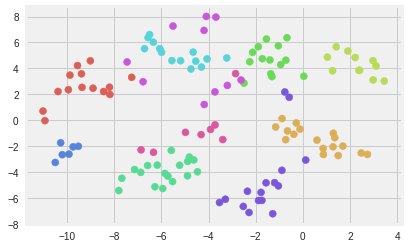

Train Epoch: 19 [38400/60000 (64%)]	Loss: -10790.911133, 	 
Train Epoch: 19 [51200/60000 (85%)]	Loss: -10795.057617, 	 
Computing latent space projection...


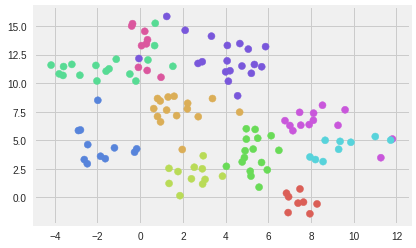

  0%|          | 1/469 [05:07<39:59:10, 307.59s/it, loss=-1.05e+6]


==> Epoch 19, average loss: -10763.1696


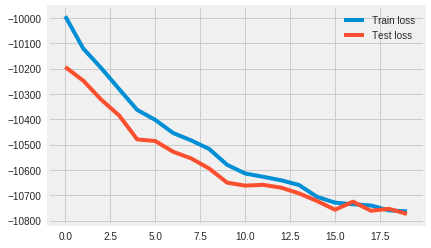

In [53]:
train_losses = []
test_losses = []
for epoch in range(Params.epochs):
  train_loss = train_epoch(epoch)
  train_losses.append(train_loss)
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, Params.epochs, train_loss)
  test_loss = test_epoch(epoch)
  message = 'Epoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, Params.epochs, test_loss)
  test_losses.append(test_loss)
  


plt.plot(range(Params.epochs),train_losses)
plt.plot(range(Params.epochs),test_losses)
plt.legend(["Train loss","Test loss"])
plt.show()
        
         

# Part 2 - Comparing Classifier Performance

1. VAE - with classifer loss and without classifier loss

## Network

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    
    ## Define NN - 5 hidden layers 1024 hidden units
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1024)
    self.fc4 = nn.Linear(1024, 1024)
    self.fc5 = nn.Linear(1024, 10)
    
  
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    
    x = self.fc5(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features
    
    

class ConvVAEClassifier(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAEClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Linear(1024, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 1024)
        
        
        
        self.fc4 = nn.Linear(1024,7*7*64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        
        
        ## Classifier
        ## classifier
        self.classifier =  Classifier()# out classifier
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = (self.conv1(x))
        x =  (self.conv2(x))
        x =  (self.conv3(x))
        x =  (self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
        return self.sigmoid(x)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decodedx = self.decode(z)
        
        return decodedx, mu, logvar, self.classifier(decodedx.view(-1,28*28))

In [15]:
modelC = ConvVAEClassifier(Params.nb_latents)
if is_cuda:
  modelC = modelC.to(device)
  
print(modelC)

ConvVAEClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc_mean): Linear(in_features=256, out_features=5, bias=True)
  (fc_std): Linear(in_features=256, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=256, bias=True)
  (fc3): Linear(in_fe

## Train Epoch

In [0]:
## Training
from tqdm import trange
criterion = nn.CrossEntropyLoss()
classifier_model = Classifier()
if is_cuda:
  classifier_model = classifier_model.to(device)

  
# Loss and optimizer
learning_rate = 0.001
momemtum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelC.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size = 7,gamma = 0.1)

## train epoch
def train_epoch(epoch,with_classifier_loss = True):
  modelC.train()
  
  
  loss_log = RunningAverage()
  metric = AccumulatedAccuracyMetric()
  
  for i, (inputs, labels) in enumerate(train_loader):
    if is_cuda:
      inputs,labels = inputs.cuda(),labels.cuda()
        
    inputs, labels = Variable(inputs), Variable(labels)
    
    # Run the forward pass
    recon_batch, mu, logvar,outputs = modelC(inputs)
    ## Loss of VAE
    
    bceloss, kld = loss_function(recon_batch.squeeze().view(-1,28*28), inputs, mu, logvar)
    loss = bceloss + kld
    classifier_loss = criterion(outputs, labels)
    
    if with_classifier_loss:
      loss +=classifier_loss
     
    loss_log.update(loss.item())
    
    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    metric(outputs,labels)
 
  return loss_log(), metric

## Test Epoch

In [0]:
## Test Epoch
"""
Test
"""
def test_epoch(epoch, with_classifier_loss = True):
    modelC.eval()
    test_loss = RunningAverage()
    metric = AccumulatedAccuracyMetric()
    
    with torch.no_grad():
        for i, (data,labels) in enumerate(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            batch_size = data.size(0)
            
            recon_batch, mu, logvar,logits = modelC(data)
            bceloss, kld = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
            
            loss = bceloss + kld
            classifier_loss = criterion(logits, labels)
    
            if with_classifier_loss:
              loss +=classifier_loss
     
            test_loss.update(loss.item() / len(data))
            
            # 1. Log scalar values (scalar summary)
            info = { 'test_loss': loss, 'test_bce':bceloss , 'test_kld':kld, "test_classifier":classifier_loss}

            for tag, value in info.items():
                logger.scalar_summary(tag, value, epoch+1)
            
            metric(logits,labels)
            
    return test_loss(), metric

## Train Network

In [47]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epochs = Params.epochs
for epoch in range(1, Params.epochs):
  
  # Train stage
  train_loss, metric = train_epoch(epoch,True)
  train_losses.append(train_loss)
  train_accuracy.append(metric.value())
  
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
  message += '\t Average Accuracy: \t{}: {}'.format(metric.name(), metric.value())
  print(message)
  val_loss, metrics = test_epoch(epoch, True)
  test_losses.append(val_loss)
  test_accuracy.append(metrics.value())
  
  message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
  
  message += '\t Average Accuracy: \t{}: {}'.format(metrics.name(), metrics.value())

  
  print(message)

Epoch: 2/20. Train set: Average loss: -1337062.3148Average Accuracy: 	Accuracy: 93.89833333333333
Epoch: 2/20. Train set: Average loss: -1337062.3148Average Accuracy: 	Accuracy: 93.89833333333333
Epoch: 2/20. Test set: Average loss: -10550.4636Average Accuracy: 	Accuracy: 93.56
Epoch: 3/20. Train set: Average loss: -1343883.1046Average Accuracy: 	Accuracy: 94.60333333333334
Epoch: 3/20. Train set: Average loss: -1343883.1046Average Accuracy: 	Accuracy: 94.60333333333334
Epoch: 3/20. Test set: Average loss: -10615.6613Average Accuracy: 	Accuracy: 94.73
Epoch: 4/20. Train set: Average loss: -1349020.6628Average Accuracy: 	Accuracy: 95.035
Epoch: 4/20. Train set: Average loss: -1349020.6628Average Accuracy: 	Accuracy: 95.035
Epoch: 4/20. Test set: Average loss: -10623.5235Average Accuracy: 	Accuracy: 94.87
Epoch: 5/20. Train set: Average loss: -1352207.5668Average Accuracy: 	Accuracy: 95.37166666666667
Epoch: 5/20. Train set: Average loss: -1352207.5668Average Accuracy: 	Accuracy: 95.3716

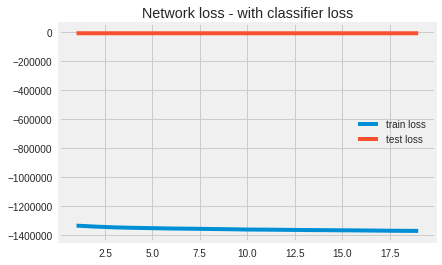

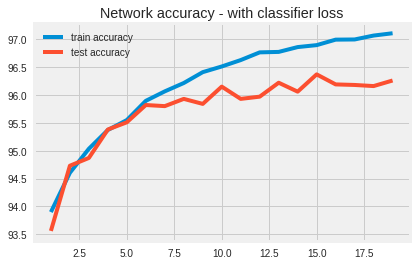

In [52]:
## Plt title

plt.plot(range(1, Params.epochs),train_losses,label="train loss")
plt.plot(range(1, Params.epochs),test_losses,label="test loss")
plt.title("Network loss - with classifier loss")
plt.legend(["train loss","test loss"])
plt.show()



plt.plot(range(1, Params.epochs),train_accuracy,label="train accuracy")
plt.plot(range(1, Params.epochs),test_accuracy,label="test accuracy")
plt.title("Network accuracy - with classifier loss")
plt.legend(["train accuracy","test accuracy"])

plt.show()



# Part 3 - Comparing Classifier - Performance - With no classifier

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    
    ## Define NN - 5 hidden layers 1024 hidden units
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 10)
    
    ## no grad to false
    self.fc1.weight.requires_grad = False
    self.fc1.bias.requires_grad = False
    
    self.fc2.weight.requires_grad = False
    self.fc2.bias.requires_grad = False
    
    self.fc3.weight.requires_grad = False
    self.fc3.bias.requires_grad = False
    
    
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features
    
    

class ConvVAEClassifierNoUpdate(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAEClassifierNoUpdate, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Linear(1024, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 1024)
        
        
        
        self.fc4 = nn.Linear(1024,7*7*64)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        
        
        ## Classifier
        ## classifier
        self.classifier =  Classifier()# out classifier
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = (self.conv1(x))
        x =  (self.conv2(x))
        x =  (self.conv3(x))
        x =  (self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
        return self.sigmoid(x)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decodedx = self.decode(z)
        
        return decodedx, mu, logvar, self.classifier(decodedx.view(-1,28*28))

## Train Epoch

In [0]:
## Training
modelC2 = ConvVAEClassifierNoUpdate(Params.nb_latents)
if is_cuda:
  modelC2 = modelC2.to(device)
  
# Loss and optimizer
learning_rate = 0.001
momemtum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelC2.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size = 7,gamma = 0.1)

## train epoch
def train_epoch(epoch,with_classifier_loss = False):
  modelC2.train()
  
  
  loss_log = RunningAverage()
  metric = AccumulatedAccuracyMetric()
  
  for i, (inputs, labels) in enumerate(train_loader):
    if is_cuda:
      inputs,labels = inputs.cuda(),labels.cuda()
        
    inputs, labels = Variable(inputs), Variable(labels)
    
    # Run the forward pass
    recon_batch, mu, logvar,outputs = modelC2(inputs)
    ## Loss of VAE
    
    bceloss, kld = loss_function(recon_batch.squeeze().view(-1,28*28), inputs, mu, logvar)
    loss = bceloss + kld
    classifier_loss = criterion(outputs, labels)
    
    if with_classifier_loss:
      loss +=classifier_loss
     
    loss_log.update(loss.item())
    
    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    metric(outputs,labels)
 
  return loss_log(), metric

## Test Epoch

In [0]:
## Test Epoch
"""
Test
"""
def test_epoch(epoch, with_classifier_loss = False):
    modelC2.eval()
    test_loss = RunningAverage()
    metric = AccumulatedAccuracyMetric()
    
    with torch.no_grad():
        for i, (data,labels) in enumerate(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            batch_size = data.size(0)
            
            recon_batch, mu, logvar,logits = modelC2(data)
            bceloss, kld = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
            
            loss = bceloss + kld
            classifier_loss = criterion(logits, labels)
    
            if with_classifier_loss:
              loss +=classifier_loss
     
            test_loss.update(loss.item() / len(data))
            
            # 1. Log scalar values (scalar summary)
            info = { 'test_loss': loss, 'test_bce':bceloss , 'test_kld':kld, "test_classifier":classifier_loss}

            for tag, value in info.items():
                logger.scalar_summary(tag, value, epoch+1)
            
            metric(logits,labels)
            
    return test_loss(), metric

## Train and Evaluate

In [58]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epochs = Params.epochs
for epoch in range(1, Params.epochs):
  
  # Train stage
  train_loss, metric = train_epoch(epoch,True)
  train_losses.append(train_loss)
  train_accuracy.append(metric.value())
  
  message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
  message += '\t Average Accuracy: \t{}: {}'.format(metric.name(), metric.value())
  print(message)
  val_loss, metrics = test_epoch(epoch, True)
  test_losses.append(val_loss)
  test_accuracy.append(metrics.value())
  
  message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
  
  message += '\t Average Accuracy: \t{}: {}'.format(metrics.name(), metrics.value())

  
  print(message)

Epoch: 2/20. Train set: Average loss: -1195367.1526	 Average Accuracy: 	Accuracy: 17.141666666666666
Epoch: 2/20. Train set: Average loss: -1195367.1526	 Average Accuracy: 	Accuracy: 17.141666666666666
Epoch: 2/20. Test set: Average loss: -9575.7823	 Average Accuracy: 	Accuracy: 17.71
Epoch: 3/20. Train set: Average loss: -1218726.2164	 Average Accuracy: 	Accuracy: 17.32
Epoch: 3/20. Train set: Average loss: -1218726.2164	 Average Accuracy: 	Accuracy: 17.32
Epoch: 3/20. Test set: Average loss: -9661.7158	 Average Accuracy: 	Accuracy: 17.92
Epoch: 4/20. Train set: Average loss: -1235954.1553	 Average Accuracy: 	Accuracy: 16.628333333333334
Epoch: 4/20. Train set: Average loss: -1235954.1553	 Average Accuracy: 	Accuracy: 16.628333333333334
Epoch: 4/20. Test set: Average loss: -9842.3630	 Average Accuracy: 	Accuracy: 16.85
Epoch: 5/20. Train set: Average loss: -1252778.9535	 Average Accuracy: 	Accuracy: 16.716666666666665
Epoch: 5/20. Train set: Average loss: -1252778.9535	 Average Accura

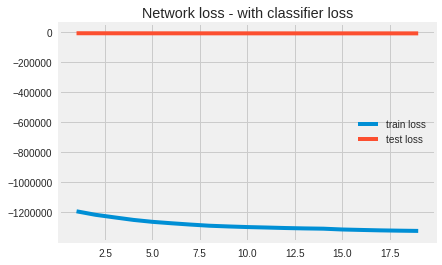

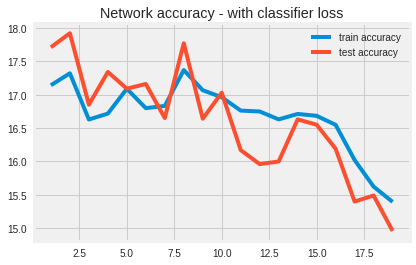

In [65]:
## Plt title

plt.plot(range(1, Params.epochs),train_losses,label="train loss")
plt.plot(range(1, Params.epochs),test_losses,label="test loss")
plt.title("Network loss - with classifier loss")
plt.legend(["train loss","test loss"])
plt.show()



plt.plot(range(1, Params.epochs),train_accuracy,label="train accuracy")
plt.plot(range(1, Params.epochs),test_accuracy,label="test accuracy")
plt.title("Network accuracy - with classifier loss")
plt.legend(["train accuracy","test accuracy"])

plt.show()


## Working with downloaded images

In [0]:
import os
import functools
import operator
import gzip
import struct
import array
import tempfile
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve  # py2
try:
    from urllib.parse import urljoin
except ImportError:
    from urlparse import urljoin
import numpy


__version__ = '0.2.2'


# `datasets_url` and `temporary_dir` can be set by the user using:
# >>> mnist.datasets_url = 'http://my.mnist.url'
# >>> mnist.temporary_dir = lambda: '/tmp/mnist'
datasets_url = 'http://yann.lecun.com/exdb/mnist/'
temporary_dir = tempfile.gettempdir


class IdxDecodeError(ValueError):
    """Raised when an invalid idx file is parsed."""
    pass


def download_file(fname, target_dir=None, force=False):
    """Download fname from the datasets_url, and save it to target_dir,
    unless the file already exists, and force is False.

    Parameters
    ----------
    fname : str
        Name of the file to download

    target_dir : str
        Directory where to store the file

    force : bool
        Force downloading the file, if it already exists

    Returns
    -------
    fname : str
        Full path of the downloaded file
    """
    target_dir = target_dir or temporary_dir()
    target_fname = os.path.join(target_dir, fname)

    if force or not os.path.isfile(target_fname):
        url = urljoin(datasets_url, fname)
        urlretrieve(url, target_fname)

    return target_fname


def parse_idx(fd):
    """Parse an IDX file, and return it as a numpy array.

    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse

    endian : str
        Byte order of the IDX file. See [1] for available options

    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file

    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))

    return numpy.array(data).reshape(dimension_sizes)


def download_and_parse_mnist_file(fname, target_dir=None, force=False):
    """Download the IDX file named fname from the URL specified in dataset_url
    and return it as a numpy array.

    Parameters
    ----------
    fname : str
        File name to download and parse

    target_dir : str
        Directory where to store the file

    force : bool
        Force downloading the file, if it already exists

    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file
    """
    fname = download_file(fname, target_dir=target_dir, force=force)
    fopen = gzip.open if os.path.splitext(fname)[1] == '.gz' else open
    with fopen(fname, 'rb') as fd:
        return parse_idx(fd)


def train_images():
    """Return train images from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    train_images : numpy.ndarray
        Numpy array with the images in the train MNIST database. The first
        dimension indexes each sample, while the other two index rows and
        columns of the image
    """
    return download_and_parse_mnist_file('train-images-idx3-ubyte.gz')


def test_images():
    """Return test images from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    test_images : numpy.ndarray
        Numpy array with the images in the train MNIST database. The first
        dimension indexes each sample, while the other two index rows and
        columns of the image
    """
    return download_and_parse_mnist_file('t10k-images-idx3-ubyte.gz')


def train_labels():
    """Return train labels from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    train_labels : numpy.ndarray
        Numpy array with the labels 0 to 9 in the train MNIST database.
    """
    return download_and_parse_mnist_file('train-labels-idx1-ubyte.gz')


def test_labels():
    """Return test labels from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    test_labels : numpy.ndarray
        Numpy array with the labels 0 to 9 in the train MNIST database.
    """
    return download_and_parse_mnist_file('t10k-labels-idx1-ubyte.gz')
  

## TSNE Plot

In [64]:
### Plot TSNE for latent space
# Show dataset images with T-sne projection of latent space encoding

2

In [0]:
train_data = train_images()
train_labels = train_labels()

In [79]:
len(train_data),len(train_labels)

(60000, 60000)

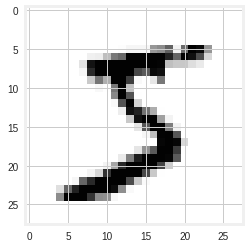

In [81]:
plt.imshow(train_data[0])

In [0]:
#train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=True)



In [0]:
data, labels = next(iter(test_loader))[:1000]


### TSNE without classifier loss

Computing latent space projection...


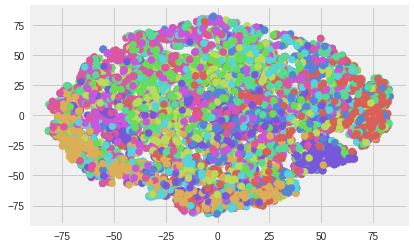

In [114]:
data = data.to(device)
labels = labels.to(device)

visualize_tsne_of_input(data,labels, modelC2, display=True)

In [108]:
print(len(test_loader.dataset))

10000


### TSNE with Classifier Loss

Computing latent space projection...


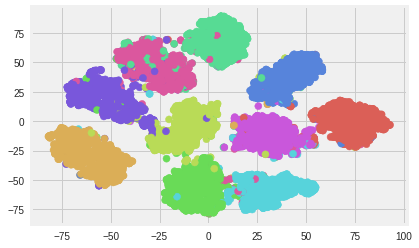

In [116]:
visualize_tsne_of_input(data,labels, modelC, display=True)

### TSNE - of VAE

Computing latent space projection...


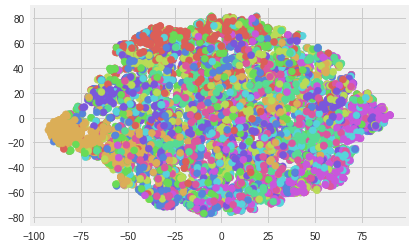

In [117]:
visualize_tsne_of_input(data,labels, model, display=True)